## Import packages

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 600

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, sys
from utils import set_seed, AverageMeter
from model import MLP
from data import get_xypp, filter_xypp, plot_x, convert2dataloader

## Set hyper-parameters

In [3]:
X_DIM = 2        # Dimension of input signal x
K_CLAS = 3       # Number of classes in the toy dataset
N_DATA = 500    # Number of samples in the dataset
N_TRAIN = 200
N_TEST = 300
RATIO = 0.5      # Ratio of sampled out training data 

BATCH_SIZE = 256 # Training batch size
HID_SIZE = 64   # Hidden size of the network
EPOCHS = 50     # Number of training epochs
LR = 1e-1        # Initial learning rate
GAMMA = 0.7      # Learning rate decay
FT_LR = LR
LR_MIN = LR      # Minimum learning rate in cosine scheduler
NOISE = 0.1      # Noisy level when generating the dataset
LS_EPS = (1-0.05)# Eps of label smoothing, label is y*eps + u*(1-eps)/K_CLAS
T_SNE_PERPLEX = 20

MU_VEC = np.random.randint(-2, 2, size=(K_CLAS, X_DIM))      # mu_1,...,mu_K
if X_DIM == 2:
  MU_VEC = np.array([[-1, 1],[1,1],[1,-1]])
optim_type = 'sgd'

In [4]:
strategy_list = ['all', 'uniform', 'reverse_prior', 
                 'cosine2mode', 'euclid2mode']
strategy2colour = {
    'all': 'k',
    'uniform': 'b',
    'reverse_prior': 'r',
    'cosine2mode': 'y',
    'euclid2mode': 'g',
}

## Generate the mulit-variate Gaussian Dataset

In this dataset, we have $N$ samples and each sample is a 3-tuple (${x},y,p^*)$. To get one sample, we first select the label $y=k$ following an uniform distribution over all $K$ classes. After that, we sample the input signal ${x}|_{y=k}\sim\mathcal{N}({\mu}_k,\sigma^2I)$, where $\sigma$ is the noisy level for all the samples. ${\mu}_k$ is the mean vector for all the samples in class $k$. Each ${\mu}_k$ is a 30-dim vector, in which each dimension is randomly selected from $\{-1,0,1\}$. Such a process is similar to selecting 30 different features for each class. Finally, we calculate the true Bayesian probability of this sample, i.e., $p^*(y|{x})$.

To calculate $p^*(y|{x})$, we use the fact that $p^*(y|{x})\propto p({x}|y)p(y)$. As $y$ follows an uniform distribution, we have $p^*(y|{x})=\frac{p({x}|y=k)}{\sum_{j\neq k}p({x}|y=j)}$. Following $p({x}|y=k)\sim\mathcal{N}({\mu}_k,\sigma^2I)$, we find $p^*(y|{x})$ should have a Softmax form, i.e., $p=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}}$. Specifically, we have:

\begin{equation}
    p^*(y=k|{x})=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}};\quad s_i = -\frac{1}{2\sigma^2}\|{x}-{\mu}_i\|^2_2
\end{equation}


### Generate dataset

In [5]:
x, y, prior, posterior = get_xypp(N_DATA, K_CLAS, X_DIM, MU_VEC, NOISE)

In [6]:
x_train, y_train, prior_train, posterior_train = \
    x[:N_TRAIN], y[:N_TRAIN], prior[:N_TRAIN], posterior[:N_TRAIN]
x_test, y_test, prior_test, posterior_test = \
    x[N_TRAIN:], y[N_TRAIN:], prior[N_TRAIN:], posterior[N_TRAIN:]

### Sample x,y from the training set following various importance weights

In [7]:
x_all, y_all, prior_all, posterior_all = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=1.0, strategy='all')

In [8]:
x_uni, y_uni, prior_uni, posterior_uni = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=RATIO, strategy='uniform')

In [9]:
x_rev, y_rev, prior_rev, posterior_rev = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=RATIO, strategy='reverse_prior')

In [10]:
x_cos, y_cos, prior_cos, posterior_cos = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=RATIO, strategy='cosine2mode')

In [11]:
x_euc, y_euc, prior_euc, posterior_euc = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=RATIO, strategy='euclid2mode')

### Visualise the sampled out data points 

In [12]:
fig = plot_x(x_train, x_uni, x_rev, x_cos, x_euc, strategy2colour)
plt.show()

## Train and Test Models with Various Importance Weights

### Create the training and testing functions

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(output, target, 
                                         reduction='sum'
                                        ).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    model.train()

    return 100. * correct / len(test_loader.dataset)

In [14]:
def train_model(x, y, x_test, y_test):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    dataloader = convert2dataloader(x, y, batch_size=BATCH_SIZE)
    test_loader = convert2dataloader(x_test, y_test, batch_size=BATCH_SIZE)
    model = MLP(in_dim=X_DIM, hid_size=HID_SIZE, out_dim=K_CLAS)
    model.to(device)
    optimiser = optim.Adam(model.parameters(), lr=LR)
    scheduler = StepLR(optimiser, step_size=2, gamma=GAMMA)

    loss_list = []
    train_acc_list = []
    test_acc_list = []

    for _ in range(EPOCHS):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimiser.step()
            loss_list.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            train_acc_list.append(100. * correct / len(data))

        test_acc = test(model, device, test_loader)
        test_acc_list.append(test_acc)
        scheduler.step()

    return loss_list, train_acc_list, test_acc_list


### Run training with different dataset

In [15]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
loss_result = {'all': [],
               'uniform': [],
               'reverse_prior': [],
               'cosine2mode': [],
               'euclid2mode': [],
              }
train_acc_result = {'all': [],
                    'uniform': [],
                    'reverse_prior': [],
                    'cosine2mode': [],
                    'euclid2mode': [],
                   }
test_acc_result = {'all': [],
                   'uniform': [],
                   'reverse_prior': [],
                   'cosine2mode': [],
                   'euclid2mode': [],
                  }

In [16]:
for seed in seeds:
    set_seed(seed)
    x, y, prior, posterior = get_xypp(N_DATA, K_CLAS, X_DIM, MU_VEC, NOISE)

    x_train, y_train, prior_train, posterior_train = \
        x[:N_TRAIN], y[:N_TRAIN], prior[:N_TRAIN], posterior[:N_TRAIN]
    x_test, y_test, prior_test, posterior_test = \
        x[N_TRAIN:], y[N_TRAIN:], prior[N_TRAIN:], posterior[N_TRAIN:]

    x_uni, y_uni, _, __ = \
    filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                percentage=RATIO, strategy='uniform')
    x_rev, y_rev, _, __ = \
        filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                    percentage=RATIO, strategy='reverse_prior')
    x_cos, y_cos, _, __ = \
        filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                    percentage=RATIO, strategy='cosine2mode')
    x_euc, y_euc, prior_euc, posterior_euc = \
        filter_xypp(x_train, y_train, prior_train, posterior_train, MU_VEC,
                    percentage=RATIO, strategy='euclid2mode')

    for (x, y, strategy) in zip([x_train, x_uni, x_rev, x_cos, x_euc],
                                [y_train, y_uni, y_rev, y_cos, y_euc],
                                strategy_list
    ):
        loss_list, train_acc_list, test_acc_list = \
            train_model(x, y, x_test, y_test)
        loss_result[strategy].append(loss_list)
        train_acc_result[strategy].append(train_acc_list)
        test_acc_result[strategy].append(test_acc_list)

## Visualise the Results

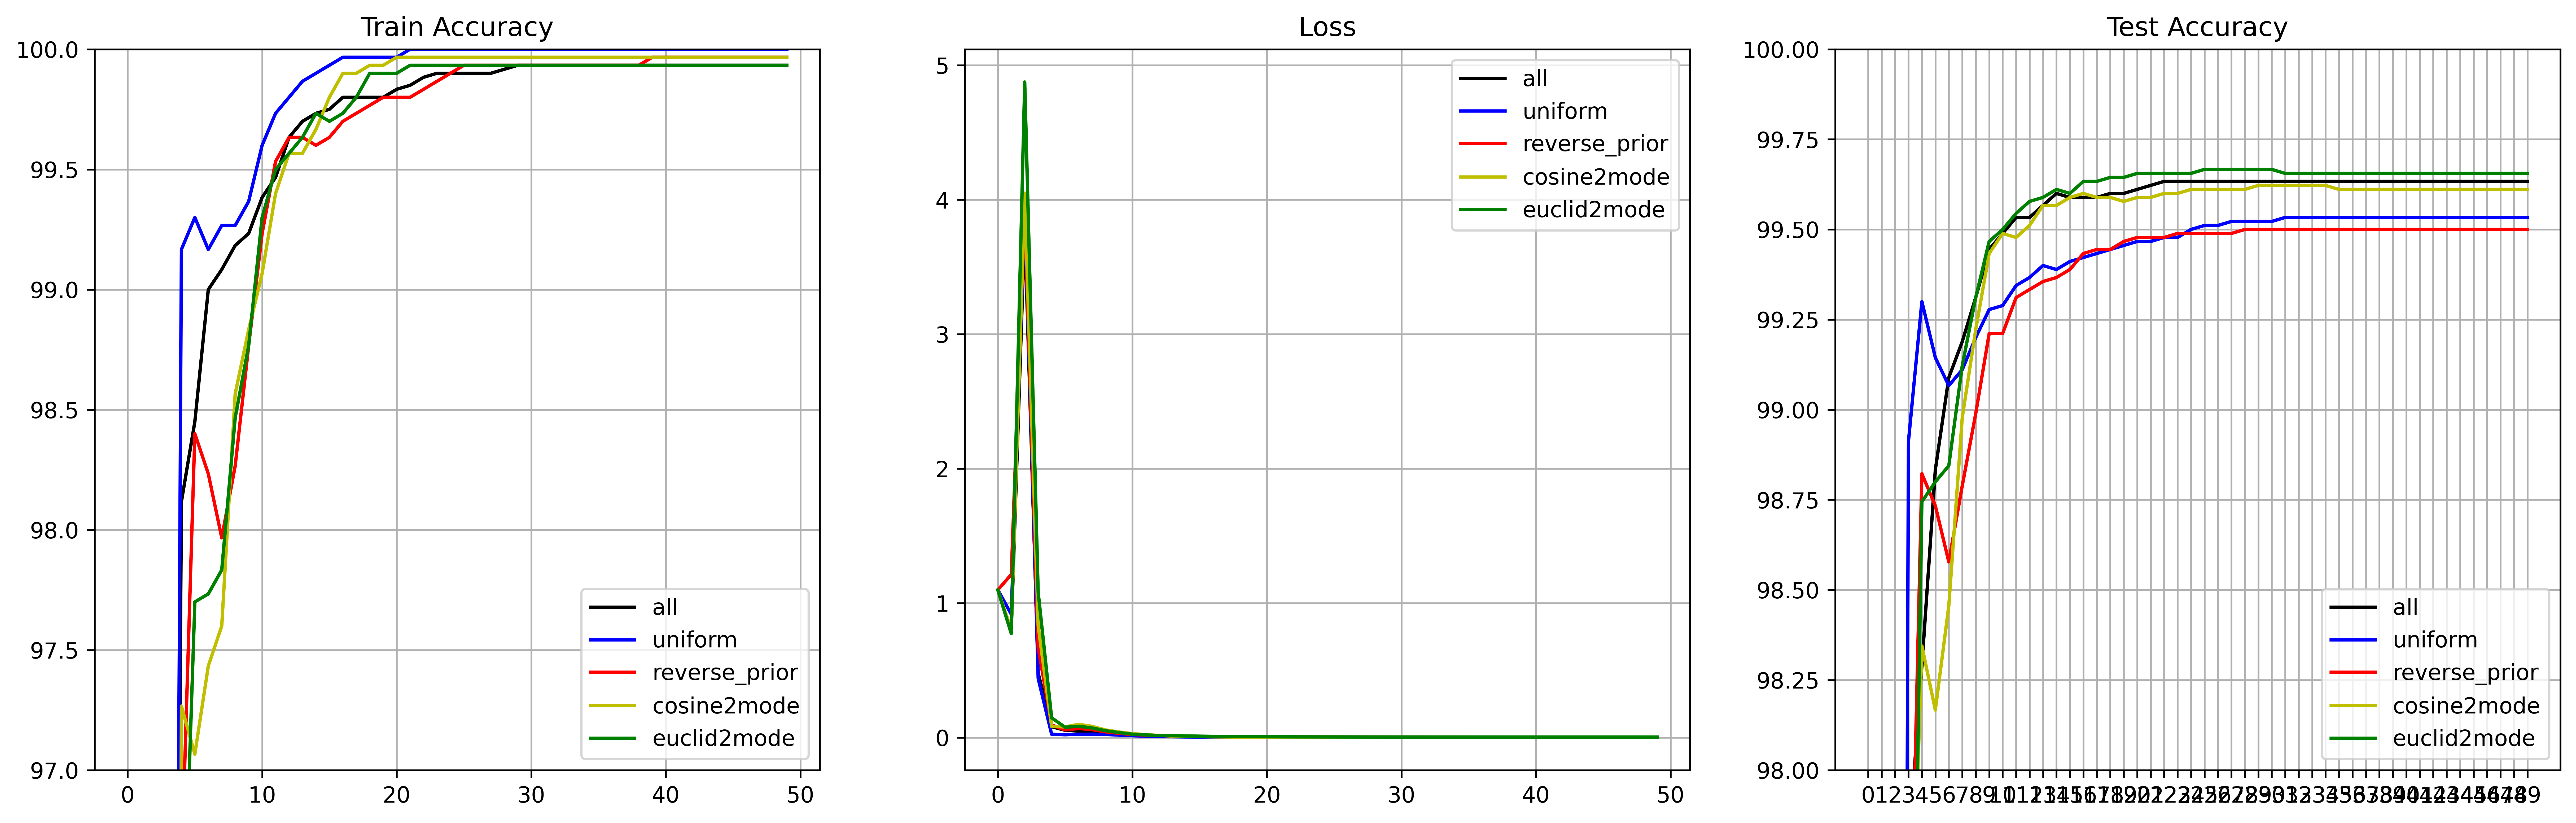

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for strategy in strategy_list:
    ax[0].plot(np.mean(train_acc_result[strategy], axis=0), 
               c=strategy2colour[strategy], label=strategy)
    ax[1].plot(np.mean(loss_result[strategy], axis=0), 
               c=strategy2colour[strategy], label=strategy)
    ax[2].plot(np.mean(test_acc_result[strategy], axis=0), 
               c=strategy2colour[strategy], label=strategy)
    for sub_ax in ax:
        sub_ax.legend()
        sub_ax.grid()
    
    ax[0].set_title('Train Accuracy')
    ax[0].set_ylim(97, 100)

    ax[1].set_title('Loss')

    ax[2].set_title('Test Accuracy')
    ax[2].set_ylim(98,100)
    ax[2].set_xticks(range(EPOCHS))
plt.show()